# 5. 가치평가없이 정책을 구할 수 있을까?
## Actor-Critic Methods with a Bootstrapping Critic
### Example : CliffWalking
#### Source
1. 예제 및 Pseudo Code from [Sutton et al. Reinforcement Learning: An Introduction]
2. Original Code from [https://github.com/dennybritz/reinforcement-learning]

<img src="img/cw_ex.png" width="50%" height="50%" title="cliff_walking" alt="cliff_walking"></img>

In [ ]:
!pip install tensorflow==1.2

In [1]:
%matplotlib inline
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import random
from utils import plot_episode_stats, EpisodeStats, CliffWalkingEnv

tf.set_random_seed(100)
np.random.seed(100)
random.seed(100)
matplotlib.style.use('ggplot')

/home/aailab/anaconda3/envs/test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aailab/anaconda3/envs/test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aailab/anaconda3/envs/test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aailab/anaconda3/envs/test/lib/python3.6/site-

<img src="img/ac_code.png" width="50%" height="50%" title="Actor_Critic" alt="Actor_Critic"></img>

In [2]:
class PolicyEstimator():

    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [3]:
class ValueEstimator():
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.train.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [4]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):

    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])    
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        episode = []
        state = env.reset()
        
        for t in itertools.count():
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update Critic
            estimator_value.update(state, td_target)
            
            # Update Actor
            estimator_policy.update(state, td_error, action)
            
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [5]:
env = CliffWalkingEnv()
global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    stats = actor_critic(env, policy_estimator, value_estimator, 200)

Step 14 @ Episode 200/200 (-15.0))

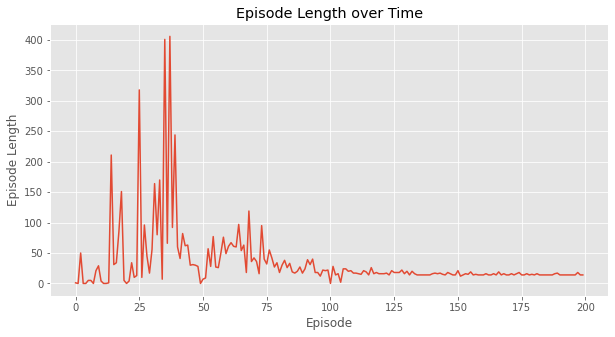

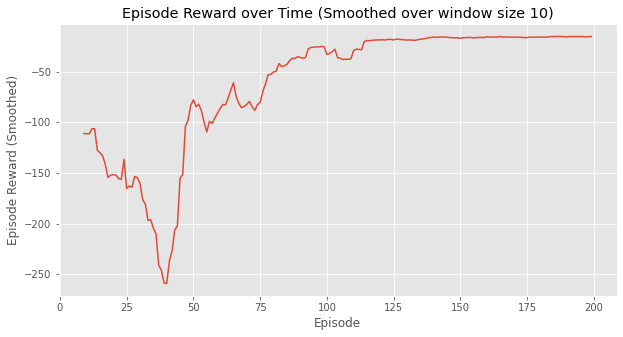

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [6]:
plot_episode_stats(stats, smoothing_window=10)